In [1]:
#! pip install fiona
#! pip install pyshp
#! pip install Basemap


# Demograpghis data mart

In [60]:
import pandas as pd

def pop_percentage(row):
    #------- Define local Variables
    out_str = ""
    Tot_Tot = 0
    i = 0
    others= 0
    others_per = 0
    others_per_str= ""
    #------- 
    
    # Read the current row,  transpose and create as dataframe
    df_1 = row.transpose()
    # Filter out the string columns
    df_test = df_1[(df_1.index!="SSC_CODE_2016") & (df_1.index!="Census_Name_2016")]
    
    df_test_1 = pd.DataFrame({'country':df_test.index, 'no_pop':df_test.values})\
                  .sort_values(by=['no_pop'],ascending=False)
    
    for values in df_test_1.T.to_dict().values():
        # check and read the Tot_Tot - Total population and assign to variable
        if values['country']=="Tot_Tot":
            Tot_Tot = values['no_pop']
            
        # check and read the Born_elsewhere_Tot - other category assign to variable
        elif values['country']=="Born_elsewhere_Tot":
            others = others + round(values['no_pop'])
        else:
            # Number of top country the the  i value 
            if (i<5):
                i = i+1
                if Tot_Tot == 0:
                    per_ = 0
                else:
                    per_  =  round((values['no_pop']/Tot_Tot ) *100, 2)
                out_str =  out_str + str(i) + "|" + (values['country'].replace("_Tot","") + "|" +str( per_) + ",")
            else:
                others= others + round(values['no_pop'])
    if Tot_Tot == 0:
        others_per = 0
    else: 
        others_per = round((others/Tot_Tot)* 100, 2)
    others_per_str = str(0) + "|other_countries|" +  str(others_per)    
    return out_str + str(others_per_str)

In [61]:
df = pd.read_csv("data/sample_out1.csv")
#df[df['Census_Name_2016'] == "Parramatta"]
#df.columns

# Get the columns that ends with _Tot - Get the county total alone
lst= [i for i in df.columns if i.endswith("_Tot")]

# Add key columns
df_sel =df[["SSC_CODE_2016", "Census_Name_2016"] + lst]

#
df_sel['pop_percentage'] = df_sel.apply(pop_percentage, axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [73]:
df_sel[df_sel.Census_Name_2016 == "Parramatta"]["pop_percentage"].tolist()

['1|India|44.16,2|China_exc_SARs_Taiwan|17.72,3|Philippines|3.3,4|Korea_Republic_South|2.25,5|Iran|2.09,0|other_countries|30.05']

## Validation of demographics 

In [98]:
per = "1|India|44.16,2|China_exc_SARs_Taiwan|17.72,3|Philippines|3.3,4|Korea_Republic_South|2.25,5|Iran|2.09,30.05"
a =0
for i in per.split(","):
    #print(i.split("|")[2])
    a = a + float(i.split("|")[2])
    print(a + 30.05)

74.21
91.92999999999999
95.22999999999999
97.47999999999999
99.57


IndexError: list index out of range

In [51]:
df_sel['Value'] = df_sel.apply(pop_percentage, axis=1)
df_sel

,SSC_CODE_2016,South_Africa_Tot,Sri_Lanka_Tot,Thailand_Tot,FYROM_Tot,Turkey_Tot,United_Kingdom_Tot,Vietnam_Tot,Zimbabwe_Tot,Born_elsewhere_Tot,...,Egypt_Tot,Fiji_Tot,Germany_Tot,Greece_Tot,Hong_Kong_SAR_China_Tot,India_Tot,Indonesia_Tot,Iran_Tot,Iraq_Tot,Value
3155,SSC13156,38,183,117,3,55,240,202,20,2078,...,77,142,41,94,290,7693,117,364,95,44.156813


# Google api call

In [54]:
#! pip install python-google-places
from googleplaces import GooglePlaces, types, lang
import gmaps
import googlemaps

def get_google_data(_location, _keyword, _distance_radius):
    YOUR_API_KEY = ''
    gmaps = googlemaps.Client(key=YOUR_API_KEY)
    google_places = GooglePlaces(YOUR_API_KEY)
    
    
    geocode_result = gmaps.geocode(_location)
    loc_lat = str(geocode_result[0]["geometry"]["location"]['lat'])
    loc_lng = str(geocode_result[0]["geometry"]["location"]['lng'])
    loc_lat_lng = loc_lat + ' ' + loc_lng
    
    query_result = google_places.nearby_search(
                                                location=_location, 
                                                keyword=_keyword,
                                                radius=_distance_radius, 
                                                rankby='distance'
                                              )
    tgt_lat = str(query_result.raw_response['results'][0]['geometry']['location']['lat'])
    tgt_lng = str(query_result.raw_response['results'][0]['geometry']['location']['lng'])
    closest_point = query_result.raw_response['results'][0]['name']
    directions_result = gmaps.directions(loc_lat_lng, (tgt_lat ,tgt_lng),mode="walking")
    walking_distance = str(directions_result[0]['legs'][0]['distance']['text'])
    walking_duration = str(directions_result[0]['legs'][0]['duration']['text'])
    
    print("Address Location" + _location)
    print("Address Location Lat" + loc_lat)
    print("Address Location Lng" + loc_lng)
    print("Focal Point Name" + _keyword)
    print("Closest {0} ".format(_keyword) + query_result.raw_response['results'][0]['name'])
    print("lat " + tgt_lat)
    print("lng " + tgt_lng)
    print("Walking Distance - " + walking_distance )
    print("Walking time - " + walking_duration )
    
    
    print(_location + "|" + 
          loc_lat   + "|" + 
          loc_lng   + "|" + 
          closest_point  + "|" + 
          tgt_lat   + "|" + 
          tgt_lng   + "|" + 
          walking_distance + "|"+
          walking_duration
         )

get_google_data("25 Campbell St Parramatta", "Aldi", 2000)    

ModuleNotFoundError: No module named 'googleplaces'

In [61]:
! pip install shapely
import shapefile
from shapely.geometry import Point # Point class
from shapely.geometry import shape # shape() is a function to convert geo objects through the interface

def get_catchment_school(lat,lng):
    point = (lng,lat) # an x,y tuple
    shp = shapefile.Reader('data/nsw_school_catchments/catchments.shp') #open the shapefile
    all_shapes = shp.shapes() # get all the polygons
    all_records = shp.records()
    for i in range(0,len(all_shapes)):
        boundary = all_shapes[i] # get a boundary polygon
        if Point(point).within(shape(boundary)): # make a point and see if it's in the polygon
            name = all_records[i][2] # get the se
            s_id = all_records[i][1]
            _id = all_records[i][0]
            print(all_records[i])
            print ("The point is in "  + name + s_id + _id)   
get_catchment_school(-33.8187468,151.0009963)

Record #379 
The point is in Arthur Phillip HSHIGH_COED8892
Record #775 
The point is in Parramatta PSPRIMARY2840


In [27]:
import requests
def get_schools_rating():
    response = requests.get(url)
    if (response.status_code==200):

In [37]:
url = 'https://data.cese.nsw.gov.au/data/api/3/action/datastore_search?resource_id=ec34b79d-25e7-3ffb-9cb7-4a252d0000f3&limit=5&q=title:jones'  
fileobj = requests.get(url)
fileobj.content

In [43]:
fileobj.content

b'{"help": "https://data.cese.nsw.gov.au/data/api/3/action/help_show?name=datastore_search", "success": true, "result": {"resource_id": "ec34b79d-25e7-3ffb-9cb7-4a252d0000f3", "fields": [{"type": "int4", "id": "_id"}, {"type": "numeric", "id": "School Code"}, {"type": "text", "id": "School Name"}, {"type": "text", "id": "Level of Schooling"}, {"type": "numeric", "id": "Calendar Year"}, {"type": "numeric", "id": "Kindergarten"}, {"type": "numeric", "id": "Year 1"}, {"type": "numeric", "id": "Year 2"}, {"type": "numeric", "id": "Year 3"}, {"type": "numeric", "id": "Year 4"}, {"type": "numeric", "id": "Year 5"}, {"type": "numeric", "id": "Year 6"}, {"type": "numeric", "id": "Primary Ungraded"}, {"type": "numeric", "id": "Year 7"}, {"type": "numeric", "id": "Year 8"}, {"type": "numeric", "id": "Year 9"}, {"type": "numeric", "id": "Year 10"}, {"type": "numeric", "id": "Year 11"}, {"type": "numeric", "id": "Year 12"}, {"type": "text", "id": "Secondary Ungraded"}, {"type": "numeric", "id": "S

In [13]:
import shapefile
from shapely.geometry import Point # Point class
from shapely.geometry import shape # shape() is a function to convert geo objects through the interface

point = (150.899601,-33.719527) # an x,y tuple
shp = shapefile.Reader('data/nsw_school_catchments/catchments.shp') #open the shapefile
all_shapes = shp.shapes() # get all the polygons
all_records = shp.records()
for i in range(0,len(all_shapes)):
    boundary = all_shapes[i] # get a boundary polygon
    if Point(point).within(shape(boundary)): # make a point and see if it's in the polygon
        name = all_records[i][2] # get the se
        s_id = all_records[i][1]
        _id = all_records[i][0]
        print(all_records[i])
        print ("The point is in "  + name + s_id + _id)   


Record #30 
The point is in Barnier PSPRIMARY4599
Record #386 
The point is in Wyndham CollegeHIGH_COED8277
Record #1506 
The point is in Quakers Hill HSHIGH_COED8594


In [175]:
sf = shapefile.Reader("data/catchments.shp")

In [176]:
shapes = sf.shapes()

In [177]:
for name in dir(shapes[3]):
    if not name.startswith('__'):
        print(name)

bbox
parts
points
shapeType


In [178]:
shapes[3].shapeType

5

In [150]:
bbox = shapes[3].bbox
['%.3f' % coord for coord in bbox]

['151.105', '-33.950', '151.134', '-33.930']

In [151]:
fields = sf.fields

In [153]:
shapeRecs = sf.iterShapeRecords()
for shapeRec in shapeRecs:
    print(shapeRec)

In [163]:
r = shapefile.Reader('data/catchments.shp')

In [173]:
for i in r.records():
    print((i))

['4401', 'PRIMARY', 'Murray Farm PS']
['8325', 'HIGH_COED', 'Moree Secondary College Albert Street Campus']
['3396', 'PRIMARY', 'Waterfall PS']
['5148', 'INFANTS', 'Bardwell Park IS']
['4314', 'PRIMARY', 'Harrington Street PS']
['1628', 'PRIMARY', 'Cooma PS']
['1455', 'PRIMARY', 'Burwood PS']
['2901', 'PRIMARY', 'Prestons PS']
['4286', 'PRIMARY', 'Camden South PS']
['2709', 'PRIMARY', 'Narrabri West PS']
['2758', 'PRIMARY', 'Narooma PS']
['5166', 'PRIMARY', 'Casino West PS']
['4168', 'PRIMARY', 'Lavington East PS']
['2846', 'PRIMARY', 'Paxton PS']
['4523', 'PRIMARY', 'Springdale Heights PS']
['2378', 'PRIMARY', 'Lavington PS']
['3986', 'PRIMARY', 'Yennora PS']
['8232', 'HIGH_COED', 'Chatswood HS']
['4461', 'PRIMARY', 'Guise PS']
['3765', 'PRIMARY', 'Bundeena PS']
['3944', 'PRIMARY', 'Beverly Hills North PS']
['3948', 'PRIMARY', 'Tempe PS']
['8374', 'HIGH_COED', 'Brisbane Water Secondary College Woy Woy Campus']
['2003', 'PRIMARY', 'Glenhaven PS']
['4496', 'PRIMARY', 'Dulwich Hill PS']


['1952', 'PRIMARY', 'Galston PS']
['1205', 'PRIMARY', 'Berowra PS']
['3632', 'PRIMARY', 'Fairfield Heights PS']
['2417', 'PRIMARY', 'Lochinvar PS']
['2454', 'PRIMARY', 'Malabar PS']
['1015', 'PRIMARY', 'Albion Park PS']
['3421', 'PRIMARY', 'Wentworth PS']
['2730', 'PRIMARY', 'Neutral Bay PS']
['2647', 'PRIMARY', 'Mount Pleasant PS']
['2658', 'PRIMARY', 'Mulbring PS']
['4514', 'PRIMARY', 'King Street PS']
['4613', 'PRIMARY', 'Hinchinbrook PS']
['2211', 'PRIMARY', 'Iona PS']
['1494', 'PRIMARY', 'Canley Vale PS']
['8832', 'HIGH_BOYS', 'Ashfield BHS']
['2965', 'PRIMARY', 'Richmond North PS']
['4483', 'PRIMARY', 'Grose View PS']
['3847', 'PRIMARY', 'Bathurst South PS']
['1483', 'PRIMARY', 'Camdenville PS']
['7431', 'PRIMARY', 'Newtown PS']
['7436', 'PRIMARY', 'Stanmore PS']
['8485', 'HIGH_COED', 'Hoxton Park HS']
['4506', 'PRIMARY', 'Toormina PS']
['4598', 'PRIMARY', 'Hassall Grove PS']
['4576', 'PRIMARY', 'William Dean PS']
['2887', 'PRIMARY', 'Plumpton PS']
['4590', 'PRIMARY', 'Hambledon 

## GNAF

In [37]:
#df_gnaf = pd.read_csv("data/gnaf_201808.csv", sep='|')
#df_gnaf_nsw = pd.read_csv("data/gnaf_nsw_201808.csv", sep='|')
#df_gnaf.columns

In [2]:
%matplotlib inline

# Read sold data and process 

In [3]:
import csv

cols = """Record_Type
District Code
Property Id
Sale Counter
Download Date Time
Property Name
Property Unit Number
Property House Number
Property Street Name
Property Locality
Property Post Code
Area
Area Type
Contract Date
Settlement Date
Purchase Price
Zoning
Nature of Property
Primary Purpose
Strata Lot Number
Component code
Sale Code
Percentage Interest of Sale
Dealing Number
Empty"""
col_header = [((i.replace(" ","_").replace("\n", ",")).split(",")) for i in cols.split('/n')]


df = pd.read_csv("data/processed/B_str.csv", sep=';', error_bad_lines=False, quoting=csv.QUOTE_NONE, encoding='utf-8')
df.columns = col_header[0]
df['Download_Date'] = pd.to_datetime(df['Download_Date_Time'].str[:8]) 


df_dedup = df.drop_duplicates(subset=[i for i in df.columns if i != 'Download_Date'], keep=False)

In [7]:
df_dedup.head(1)


,Record_Type,District_Code,Property_Id,Sale_Counter,Download_Date_Time,Property_Name,Property_Unit_Number,Property_House_Number,Property_Street_Name,Property_Locality,...,Zoning,Nature_of_Property,Primary_Purpose,Strata_Lot_Number,Component_code,Sale_Code,Percentage_Interest_of_Sale,Dealing_Number,Empty,Download_Date
0,B,1,2005.0,2,2017050101:00,NaN,NaN,29,ARMIDALEST,ABERMAIN,...,R2,R,RESIDENCE,NaN,AAM,NaN,0.0,AM321605,NaN,2017-05-01


In [9]:
df_time_ser_price = df_dedup[(df_dedup.Nature_of_Property == 'R')]\
                            [['Download_Date','Property_Locality', "Purchase_Price"]]\
                            .groupby(['Property_Locality','Download_Date'])\
                            .agg(['mean','count'])
df_time_ser_price =  df_time_ser_price.reset_index()
df_time_ser_price.columns = ["Property_Locality","date_sold","Purchase_Price","sold_counts"]
df_time_ser_price_Locality = df_time_ser_price[(df_time_ser_price.Property_Locality).isin([2167,2148,2147])]

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

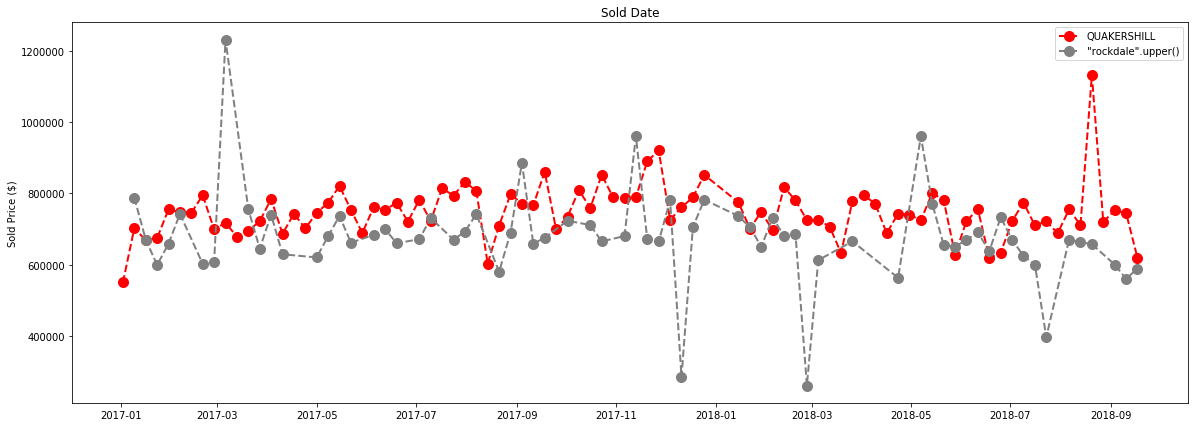

In [20]:
plt.figure(figsize=(20,7))
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="QUAKERSHILL")]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Locality=="QUAKERSHILL")]['Purchase_Price'], 
         color='red', marker='o', linestyle='dashed', linewidth=2, markersize=10,
         label = 'QUAKERSHILL')
#plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSLANGLEY")]["date_sold"], 
#         df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSLANGLEY")]['Purchase_Price'], 
#         color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10,
#         label = 'KINGSLANGLEY')
#plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="MARAYONG")]["date_sold"], 
#         df_time_ser_price[(df_time_ser_price.Property_Locality=="MARAYONG")]['Purchase_Price'], 
#         color='Blue', marker='o', linestyle='dashed', linewidth=2, markersize=10,
#         label = 'MARAYONG')
#plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSPARK")]["date_sold"], 
#         df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSPARK")]['Purchase_Price'], 
#         color='Yellow', marker='o', linestyle='dashed', linewidth=2, markersize=10,
#         label = 'KINGSPARK')

plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="Glendenning".upper())]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Locality=="Glendenning".upper())]['Purchase_Price'], 
         color='Gray', marker='o', linestyle='dashed', linewidth=2, markersize=10,
         label = '"rockdale".upper()')




plt.ylabel('Sold Price ($)') 
plt.title('Sold Date')
plt.legend();
plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

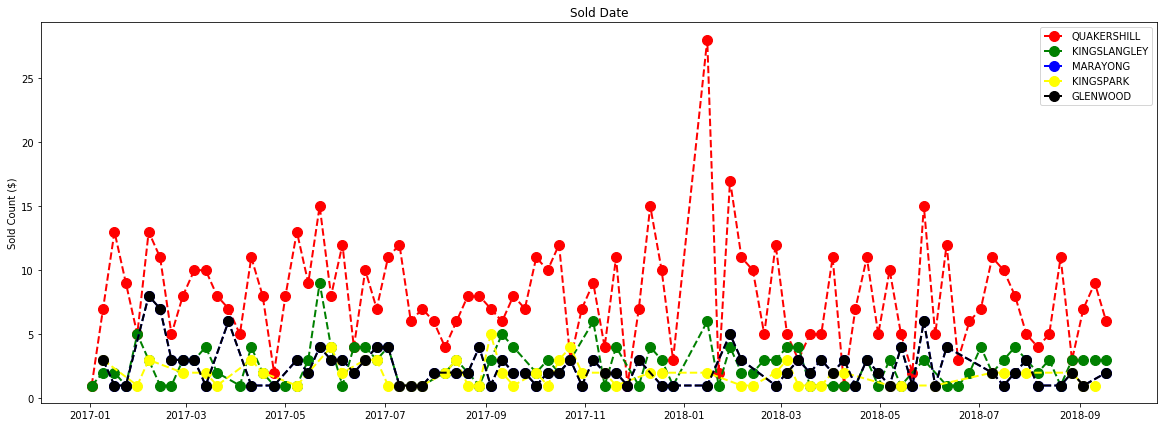

In [11]:
plt.figure(figsize=(20,7))
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="QUAKERSHILL")]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Locality=="QUAKERSHILL")]['sold_counts'], 
         color='red', marker='o', linestyle='dashed', linewidth=2, markersize=10,
         label = 'QUAKERSHILL')
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSLANGLEY")]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSLANGLEY")]['sold_counts'], 
         color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10,
         label = 'KINGSLANGLEY')
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="MARAYONG")]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Locality=="MARAYONG")]['sold_counts'], 
         color='Blue', marker='o', linestyle='dashed', linewidth=2, markersize=10,
         label = 'MARAYONG')
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSPARK")]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Locality=="KINGSPARK")]['sold_counts'], 
         color='Yellow', marker='o', linestyle='dashed', linewidth=2, markersize=10,
         label = 'KINGSPARK')
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Locality=="MARAYONG")]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Locality=="MARAYONG")]['sold_counts'], 
         color='Black', marker='o', linestyle='dashed', linewidth=2, markersize=10,
         label = 'GLENWOOD')



plt.ylabel('Sold Count ($)') 
plt.title('Sold Date')
plt.legend();
plt

In [13]:
plt.figure(figsize=(20,7))
#x=df_time_ser_price['date_sold']
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Post_Code==2167)]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Post_Code==2167)]['Purchase_Price'], 
         color='red', marker='o', linestyle='solid', linewidth=2, markersize=10,
         label = 'Quakers_hill')
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Post_Code==2147)]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Post_Code==2147)]['Purchase_Price'], 
         color='green', marker='o', linestyle='solid', linewidth=2, markersize=10,
         label = 'Kings_Langly')
plt.plot(df_time_ser_price[(df_time_ser_price.Property_Post_Code==2148)]["date_sold"], 
         df_time_ser_price[(df_time_ser_price.Property_Post_Code==2148)]['Purchase_Price'], 
         color='Blue', marker='o', linestyle='solid', linewidth=2, markersize=10,
         label = 'BlackTown')
plt.ylabel('Sold count - in no.') 
plt.title('Sold Date')
plt.legend();
plt

AttributeError: 'DataFrame' object has no attribute 'Property_Post_Code'

<Figure size 1440x504 with 0 Axes>

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

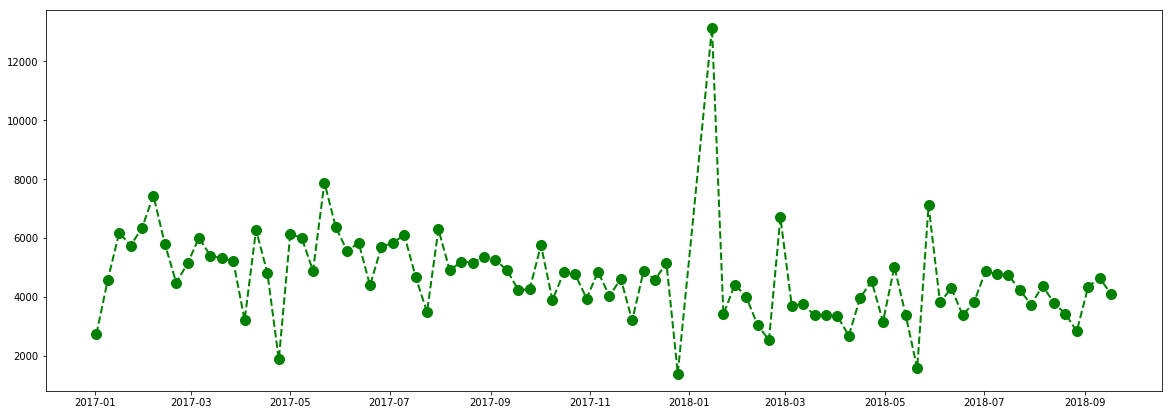

In [14]:
df_time_ser = df[['Download_Date','Property_Post_Code']].groupby(['Download_Date']).agg(['count'])
df_time_ser_col =  df_time_ser.reset_index()
df_time_ser_col.columns = ["date_sold","no_property_sold"]
plt.figure(figsize=(20,7))
x=df_time_ser_col['date_sold']
y=df_time_ser_col['no_property_sold']
plt.plot(x,y , color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10)
plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

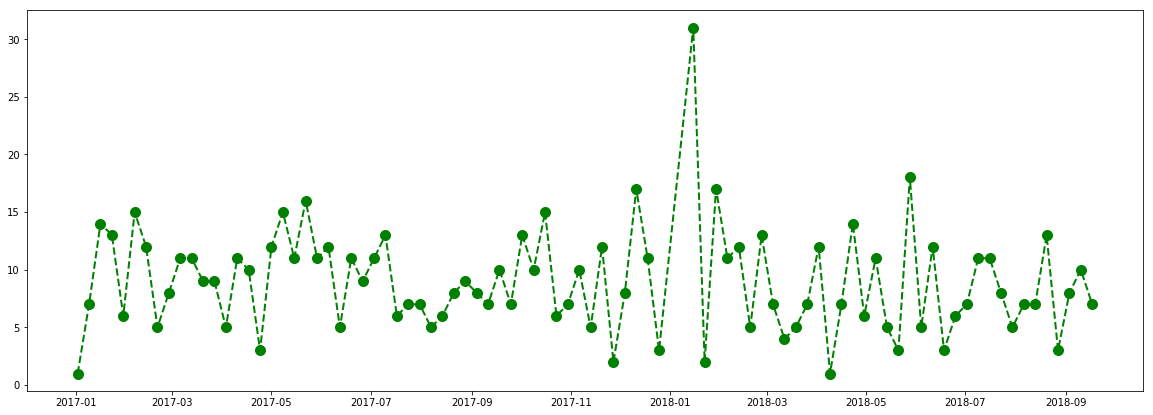

In [15]:
#df_time_ser = df[(df.Property_Post_Code == 2150)].df[['Download_Date','Property_Post_Code']].groupby(['Download_Date']).agg(['count'])
df_time_ser = df[(df.Property_Post_Code == 2763) & 
                 (df.Primary_Purpose == 'RESIDENCE')][['Download_Date','Property_Post_Code']].groupby(['Download_Date']).agg(['count'])
df_time_ser_col =  df_time_ser.reset_index()
df_time_ser_col.columns = ["date_sold","no_property_sold"]
plt.figure(figsize=(20,7))
x=df_time_ser_col['date_sold']
y=df_time_ser_col['no_property_sold']
plt.plot(x,y , color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10)
plt